In [1]:
import graph as gr
import numpy as np
import networkx as nx

import torch
torch.manual_seed(12121998)
import torch.nn.functional as F

from torch.nn import Linear, ReLU
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import ResGatedGraphConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import GENConv
from torch_geometric.nn.models import basic_gnn as torch_models
from torch_geometric.nn.models import mlp

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import time

# Creating Dataset

In [2]:
# MACROS
COORDINATES_FEATURE_FLAG = False # If true also position is used as feature!
NORMALIZE_TARGET_FLAG    = True # normalize output!
norm_inter = [0, 1] # Interval where to normalize data

In [3]:
# FILENAMES AND FILEPATH

# mesh name
mesh_filename = "simple_laplacian_mesh"
## target filepaths (you can add other targets)
target_filepaths  = ["../mesh/simple_laplacian_u.txt"]
## feature filepaths 
feature_filepaths = ["../mesh/simple_laplacian_f.txt"]

In [4]:
folder = gr.import_mesh(mesh_filename)
loaded_graph = gr.build_graph(folder)
loaded_adj = gr.build_adjacency(loaded_graph, folder)

loaded_targets = [torch.tensor(0)] * len(target_filepaths)
for i, data in enumerate(target_filepaths):
    loaded_targets[i] = torch.tensor(gr.import_features(data)).double()

loaded_features = [torch.tensor(0)] * len(feature_filepaths)
for i, data in enumerate(feature_filepaths):
    loaded_features[i] = torch.tensor(gr.import_features(data)).double()


if NORMALIZE_TARGET_FLAG:
    u_max = [None] * len(loaded_targets)
    u_min = [None] * len(loaded_targets)
    for i, data in enumerate(loaded_targets):
        u_max[i] = data.max()
        u_min[i] = data.min()
        loaded_targets[i] = (norm_inter[1] - norm_inter[0]) * (data - u_min[i]) / (u_max[i] - u_min[i]) + norm_inter[0]  


In [5]:
## TORCH DATASET (see torch_geometric.data)

# will be used to create the complete dataset
tot_samples = loaded_targets[0].shape[1]
data_list = [torch.tensor(0)] * tot_samples

# INITIALIZING COMMON PROPERTIES TO ALL GRAPHS

# Graph connectivity
edge_index = torch.tensor([ [i,j] for i in range(loaded_adj.shape[0]) for j in range(loaded_adj.shape[1]) if loaded_adj[i,j]>0 ])

# Node position matrix
pos = torch.hstack((
                    torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'x').values())), 1 ),
                    torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'y').values())), 1 ) 
                  )).double()


In [6]:
# INITIALIZING THE DIFFERENT GRAPHS

for t in range(tot_samples):
    
    ## Node feature matrix
    
    x = loaded_features[0][:, t][:, None]
    # other features (forcing f values)
    [x := torch.hstack((x, loaded_features[j][:, t][:, None])) for j in range(1,len(loaded_features))]
    if COORDINATES_FEATURE_FLAG: [x := torch.hstack((x, pos))]
    
    ## Node-level ground-truth labels (heat)
    
    # first feature (pression or velocity or ...)
    y = loaded_targets[0][:, t][:, None]
    # other features (pression, velocities, ...)
    [y := torch.hstack((y, loaded_targets[j][:, t][:, None])) for j in range(1,len(loaded_targets))]

    data_list[t] = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, pos=pos)

In [7]:
# BORDER MASK
label = torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'n').values())), 1).double()
mask  = label == 0.

In [8]:
dataloader = DataLoader(data_list, batch_size = 1, shuffle = True)

# Model

In [9]:
conv_input_size = dataloader.dataset[0].num_node_features
input_size      = dataloader.dataset[0].num_nodes
output_size     = dataloader.dataset[0].num_nodes
feature_size    = dataloader.dataset[0].x.size()[-1]

In [10]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.heads1 = 8
#         self.conv1 = GATConv(conv_input_size, conv_input_size, heads = self.heads1, concat = False, dropout = 0.)
        
#         self.nn = Linear(input_size, output_size)
        

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.nn(torch.flatten(x))
#         x = torch.tanh(x)
                
#         return x[:, None]
        
# GAT_model = GAT().double()
# print(GAT_model)


GAT(
  (conv1): GATConv(1, 1, heads=8)
  (nn): Linear(in_features=1089, out_features=1089, bias=True)
)


In [11]:
# from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.conv1 = GatedGraphConv(out_channels = 1, num_layers = 2, aggr = "mean")
                

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.tanh(x)
                
#         return x
        
# GAT_model = GAT().double()
# print(GAT_model)


In [12]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.heads1 = 64
#         self.conv1 = TransformerConv(conv_input_size, conv_input_size, heads = self.heads1, concat = True, beta = True, dropout = 0.)
        
#         self.heads2 = 16
#         self.conv2 = GATConv(self.heads1 * conv_input_size, conv_input_size, heads = self.heads2, concat = False, dropout=0.)
        
        

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, edge_index)
#         x = torch.relu(x)
#         #x = self.conv3(x, edge_index)
#         #x = torch.tanh(x)
                
#         return x
        
# GAT_model = GAT().double()
# print(GAT_model)


In [13]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.heads1 = 64
#         self.conv1 = GATConv(conv_input_size, conv_input_size, heads = self.heads1, concat = True, dropout = 0.)
        
#         self.heads2 = 32
#         self.conv2 = GATConv(self.heads1 * conv_input_size, conv_input_size, heads = self.heads2, concat = True, dropout=0.)
                
#         self.nn = torch.nn.Sequential(
#             Linear(self.heads2  * conv_input_size, 16),
#             ReLU(),
#             Linear(16, 16),
#             ReLU(),
#             Linear(16, feature_size),
#         )
        
#         self.conv3 = GINConv(self.nn, train_eps=False)
      

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv3(x, edge_index)
#         x = torch.tanh(x)
                
#         return x
        
# GAT_model = GAT().double()
# print(GAT_model)


In [14]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.heads1 = 16
#         self.conv1 = GATConv(conv_input_size, conv_input_size, heads = self.heads1, concat = True, dropout = 0.)
        
#         self.heads2 = 8
#         self.conv2 = GATConv(self.heads1 * conv_input_size, conv_input_size, heads = self.heads2, concat = True, dropout = 0.)
        
        
#         self.conv3 = GENConv(self.heads2 * conv_input_size, 1, aggr = "mean", num_layers=3)
      

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv2(x, edge_index)
#         x = torch.relu(x)
#         x = self.conv3(x, edge_index)
#         x = torch.tanh(x)

#         return x
        
# GAT_model = GAT().double()
# print(GAT_model)

In [51]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
                
#         self.nn = torch.nn.Sequential(
#             Linear(conv_input_size, 4),
#             Linear(4, feature_size),
#         )
        
#         self.conv1 = GINConv(self.nn, train_eps=True)      

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.tanh(x)

#         return x
        
# GAT_model = GAT().double()
# print(GAT_model)

GAT(
  (nn): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=1, bias=True)
  ))
)


In [ ]:
# #from torch_geometric.nn import Sequential
# class GAT(torch.nn.Module):

#     def __init__(self):
#         super().__init__()
        
#         self.nn = torch.nn.Sequential(
#             Linear(conv_input_size, 64),
#             ReLU(),
#             Linear(64, feature_size)
#         )
        
#         self.conv1 = GINConv(self.nn, train_eps=False)   
        
#         # self.fc = torch.nn.Sequential(
#         #     Linear(input_size, 512),
#         #     ReLU(),
#         #     Linear(512, 512),
#         #     ReLU(),
#         #     Linear(512, output_size)
#         # )
        

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = torch.relu(x)
#         #x = torch.tanh(self.fc(x.T))        
        
#         return x

# GAT_model = GAT().double()
# print(GAT_model)

In [48]:
learning_rate = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(GAT_model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [52]:
def train_loop(dataloader, model, loss_fn, optimizer):
    tot_loss = 0
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(data.x, data.edge_index)
        #loss = loss_fn(pred[mask], data.y[mask])
        loss = loss_fn(pred, data.y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tot_loss += loss.item()
    print("loss: {:1.3e}".format(tot_loss / len(dataloader)))

In [53]:
epochs = 20
start = time.time()

for t in range(epochs):
    print("-------------------------------")
    print(f"Epoch {t+1}")
    train_loop(dataloader, GAT_model, loss_fn, optimizer)
print("-------------------------------")
print("Done!")

end = time.time()
elapsed_time = end - start
minutes = elapsed_time //60
seconds = elapsed_time - 60*minutes
print(f"Elapsed time: {minutes:2.0f} min, {seconds:2.0f} sec")

-------------------------------
Epoch 1
loss: 1.377e+00
-------------------------------
Epoch 2
loss: 1.377e+00
-------------------------------
Epoch 3
loss: 1.377e+00
-------------------------------
Epoch 4
loss: 1.377e+00
-------------------------------
Epoch 5
loss: 1.377e+00
-------------------------------
Epoch 6
loss: 1.377e+00
-------------------------------
Epoch 7
loss: 1.377e+00
-------------------------------
Epoch 8
loss: 1.377e+00
-------------------------------
Epoch 9


KeyboardInterrupt: 

In [39]:
def denormalize(tensor):
    tensor = (tensor - norm_inter[0]) / (norm_inter[1] - norm_inter[0])
    tensor = tensor * (u_max[0] - u_min[0]) + u_min[0]
    return tensor[:,0].clone().detach()

true = denormalize(data_list[999].y) 
print("True values: ")
print(true)

pred = denormalize(GAT_model(dataloader.dataset[999]['x'], dataloader.dataset[0]['edge_index']))
print("Prediction: ")
print(pred)

True values: 
tensor([1.0000, 1.0000, 1.0004,  ..., 3.7360, 3.8637, 4.0000],
       dtype=torch.float64)
Prediction: 
tensor([ 0.4907,  0.1990, -0.0526,  ..., -1.9995, -1.9996, -1.9976],
       dtype=torch.float64)


In [24]:
L1_loss = torch.nn.L1Loss()
L2_loss = torch.nn.MSELoss()

err = {
    "Mean Absolute Error": L1_loss(true, pred).item(),
    "Mean Squared Error":  L2_loss(true, pred).item(),
    "Minimum Error": abs(true - pred).min().item(),
    "Maximum Error": abs(true - pred).max().item(),
    "Average Error": abs(true - pred).mean().item() 
    }

# print each data item.
for key, value in err.items():
    print ("{:<20} {:1.3e}".format(key, value))

Mean Absolute Error  2.732e-02
Mean Squared Error   1.495e-03
Minimum Error        5.410e-07
Maximum Error        2.547e-01
Average Error        2.732e-02


In [25]:
def plot(ax, dataloader, output, title):
    
    # plots a finite element mesh
    def plot_fem_mesh(nodes_x, nodes_y, elements):
        for element in elements:
            x = [nodes_x[element[i]] for i in range(len(element))]
            y = [nodes_y[element[i]] for i in range(len(element))]
            ax.fill(x, y, edgecolor='black', fill=False, linewidth='0.5', alpha=0.3)

    # FEM data
    nodes_x = dataloader.dataset[0]['pos'][:,0]
    nodes_y = dataloader.dataset[0]['pos'][:,1]
    nodal_values = output # loaded_features[0][:, 0]
    elements = np.load(folder+"/triangles.npy")
    triangulation = tri.Triangulation(nodes_x, nodes_y, elements)

    # plot the contours
    tcf = ax.tricontourf(triangulation,  nodal_values)
    plt.colorbar(tcf, ax=ax)

    # plot the finite element mesh
    plot_fem_mesh(nodes_x, nodes_y, elements)
    #ax.axis('equal')
    ax.set_title(title, fontsize=20)


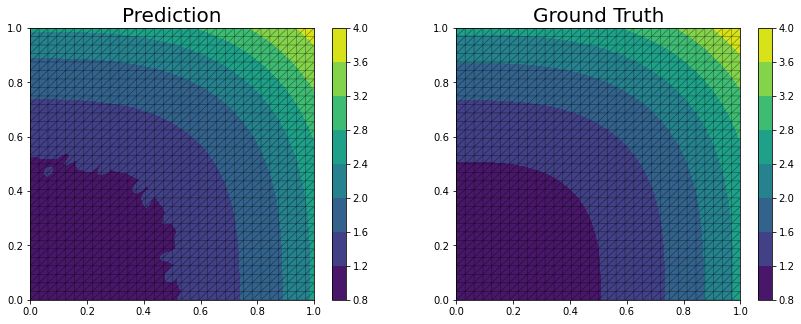

In [26]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
plot(axs[0], dataloader, pred, "Prediction")
plot(axs[1], dataloader, true, "Ground Truth")
plt.show()

In [22]:
len(dataloader)

1000